In [2]:
# Load python packages
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.sparse as sparse
import statsmodels.api as sm

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [3]:
%%R
# Load R packages
library(edgeR)
library(DESeq2)
library(limma)
library(glmGamPoi)
library(glmmTMB)
library(nebula)
library(fixest)
library(MAST)
library(SingleCellExperiment)
library(scuttle)
library(lme4)

## Load data

In [4]:
# Load data
adata = sc.read_h5ad('data/Kang.h5ad')
adata.obs

,n_genes,n_counts,orig_ident,stim,cluster,Donor
index,,,,,,
CTRL_AAACATACATTTCC.1,878.0,3018.0,CTRL,CTRL,CD14 Mono,SNG-1016
CTRL_AAACATACCAGAAA.1,713.0,2481.0,CTRL,CTRL,CD14 Mono,SNG-1256
CTRL_AAACATACCTCGCT.1,850.0,3420.0,CTRL,CTRL,CD14 Mono,SNG-1256
CTRL_AAACATACGGCATT.1,558.0,1582.0,CTRL,CTRL,CD14 Mono,SNG-1015
CTRL_AAACATTGCTTCGC.1,669.0,2536.0,CTRL,CTRL,CD14 Mono,SNG-1256
...,...,...,...,...,...,...
STIM_TCCCGAACTTCGTT.1,702.0,4222.0,STIM,STIM,Eryth,SNG-1015
STIM_TCGGACCTATCAGC.1,502.0,2050.0,STIM,STIM,Eryth,SNG-101
STIM_TGACGCCTCTTGTT.1,899.0,7168.0,STIM,STIM,Eryth,SNG-1015


In [5]:
adata.obs['cluster'].value_counts()

CD14 Mono       4225
CD4 Naive T     2600
CD4 Memory T    1598
B                998
CD16 Mono        974
T activated      767
CD8 T            753
NK               646
DC               463
B activated      355
Mk               289
pDC              108
Eryth             60
Name: cluster, dtype: int64

## Subsample to 5000 cells (randomly)

In [6]:
np.random.seed(0)
cell_idx_random = np.random.binomial(
    n=1,
    p=5000/adata.shape[0],
    size=adata.shape[0]
).astype(bool)
adata_sub = adata[cell_idx_random,:].copy()

## Benchmark preprocessing

1. Select cell-type.
2. Assign random treatment label.
3. Select transcripts with > 10 counts.
4. Output count matrix $\texttt{Y}$, design matrix $\texttt{X}$, size fator $\texttt{sf}$ and membership label.

In [7]:
# label definition: column name in adata.obs
var_celltype = 'cluster'
var_subject = 'Donor'
var_treat_random = 'stim'

# select transcripts with >10 counts
gene_idx_threshold = np.asarray(np.sum(adata_sub.X, axis=0) > 10).ravel()

# Produce Y, X, sf
matrix_count = adata_sub.raw.X[:, gene_idx_threshold].tocsc()
matrix_design = sm.add_constant(
    pd.get_dummies(
        adata_sub.obs[var_treat_random], 
        drop_first=True
    )
).values
cell_sizefactor = np.asarray(np.sum(adata_sub.X, axis=1)).ravel()
cell_sizefactor = cell_sizefactor / cell_sizefactor.mean()
cell_subject = pd.factorize(adata_sub.obs[var_subject])[0]

## Pseudobulk generation

1. Aggregate(=sum) cell counts according to treatment & subject label

In [8]:
# convert psueobulk label to integer
cell_label_pseudobulk, subject_label = pd.factorize(
    adata_sub.obs[var_subject].astype(str) + 
    '_' + 
    adata_sub.obs[var_treat_random].astype(str)
)

# generate summation matrix
spmatrix_subject_sum = sparse.csc_matrix(
    (
        np.ones(adata_sub.shape[0]),
        cell_label_pseudobulk,
        np.arange(adata_sub.shape[0]+1)
    ),
    shape = (
        subject_label.shape[0], 
        adata_sub.shape[0]
    )
)

# generate pseudobulk count, design matrix
matrix_pb_count = spmatrix_subject_sum.dot(
    adata_sub.raw.X
)[:, gene_idx_threshold].T
matrix_pb_design = sm.add_constant(
    pd.get_dummies(
        [x.split('_')[1] for x in subject_label], 
        drop_first=True
    )
).values


## Poisson regression (robust)

In [10]:
%%time
gene_beta_rpr = np.zeros(matrix_count.shape[1])
gene_bse_rpr = np.zeros(matrix_count.shape[1])
gene_p_rpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.Poisson(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(cov_type='HC0', tol=1e-10)
    gene_beta_rpr[gene_idx_int] = fit.params[1]
    gene_bse_rpr[gene_idx_int] = fit.bse[1]
    gene_p_rpr[gene_idx_int] = fit.pvalues[1]

CPU times: user 2h 4min 21s, sys: 2h 22min 45s, total: 4h 27min 7s
Wall time: 5min 34s


## Negative-binomial regression (glmGamPoi, robust)

In [12]:
gene_beta_ggp = np.zeros(matrix_count.shape[1])
gene_bse_ggp = np.zeros(matrix_count.shape[1])
gene_p_ggp = np.zeros(matrix_count.shape[1])
matrix_count_T = matrix_count.T.tocsc()

In [13]:
%%time
%%R -i matrix_count_T -i matrix_design -i cell_sizefactor -o gene_beta_ggp -o gene_p_ggp

matrix_count_T <- as(matrix_count_T, "dgCMatrix")
fit <- glmGamPoi::glm_gp(
    matrix_count_T, 
    matrix_design, 
    on_disk=FALSE, 
    size_factors=as.numeric(cell_sizefactor)
    )
test <- glmGamPoi::test_de(fit, contrast=`Coef_2`)

gene_beta_ggp <- summary(fit)$Beta[,2]
gene_p_ggp <- test$pval

CPU times: user 7min 43s, sys: 1min 10s, total: 8min 54s
Wall time: 2min


## Pseudobulk (edgeR)

In [14]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_edger -o gene_beta_edger
y <- edgeR::DGEList(matrix_pb_count, group=subject_label)
y <- edgeR::calcNormFactors(y)
y <- edgeR::estimateDisp(y, matrix_pb_design)
fit <- edgeR::glmQLFit(y, matrix_pb_design)
qlf <- edgeR::glmQLFTest(fit, coef=2)

gene_p_edger <- qlf$table[,'PValue']
gene_beta_edger <- qlf$table[,'logFC']

CPU times: user 3min 33s, sys: 6.44 s, total: 3min 39s
Wall time: 6 s


## Pseudobulk (DESeq2)

In [15]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_deseq2 -o gene_beta_deseq2
dds <- DESeq2::DESeqDataSetFromMatrix(
    matrix_pb_count,
    colData = matrix_pb_design,
    design = ~ 1+V2
)
dds <- DESeq2::estimateSizeFactors(dds)
dds <- DESeq2::estimateDispersions(dds, quiet = TRUE)
dds <- DESeq2::nbinomWaldTest(dds)
        
gene_beta_deseq2 <- results(dds)[,'log2FoldChange']
gene_p_deseq2 <- results(dds)[,'pvalue']

CPU times: user 1min 3s, sys: 1.75 s, total: 1min 5s
Wall time: 9.17 s


## NB mixed model (glmmTMB)

In [ ]:
%%time
%%R -i matrix_count -i matrix_design -i cell_sizefactor -i cell_subject -o gene_beta_nbmm -o gene_p_nbmm

data <- matrix_count@x
row_indices <- matrix_count@i # i,p both 0-base like base R
indptr <- matrix_count@p

gene_beta_nbmm <- rep(0, ncol(matrix_count))
gene_p_nbmm <- rep(1, ncol(matrix_count))

for (gene_idx_int in 1:ncol(matrix_count)){
    # select gene from count matrix: manual indexing for speed
    y <- rep(0, nrow(matrix_count))
    y[row_indices[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]+1] <- data[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]
    
    # design matrix for fixest
    df_matrix_design <- as.data.frame(matrix_design)
    df <- cbind(y, cell_subject, df_matrix_design)
    
    # glmer fit
    fit <- glmmTMB::glmmTMB(y ~ V2 + (1|cell_subject), data=df, offset=log(cell_sizefactor), family=nbinom2)
    
    
    gene_beta_nbmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,1]
    gene_p_nbmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,4]   
}

In [ ]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_pb_ggp -o gene_beta_pb_ggp -o size_factor_pb

fit <- glmGamPoi::glm_gp(
    as.matrix(matrix_pb_count),
    matrix_pb_design,
    on_disk=FALSE
)
test <- glmGamPoi::test_de(fit, contrast=`Coef_2`)

gene_beta_pb_ggp <- summary(fit)$Beta[,2]
gene_p_pb_ggp <- test$pval
size_factor_pb <- fit$size_factors

In [ ]:
%%time
gene_beta_pb_rpr = np.zeros(matrix_count.shape[1])
gene_bse_pb_rpr = np.zeros(matrix_count.shape[1])
gene_p_pb_rpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_pb_count.T[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_pb_design, 
        family=sm.families.Poisson(), 
        offset=np.log(size_factor_pb) 
    )
    fit = mod.fit(cov_type='HC0', tol=1e-10)
    gene_beta_pb_rpr[gene_idx_int] = fit.params[1]
    gene_bse_pb_rpr[gene_idx_int] = fit.bse[1]
    gene_p_pb_rpr[gene_idx_int] = fit.pvalues[1]

In [56]:
gene_p_nbmm[np.isnan(gene_p_nbmm)] = 1

## Result

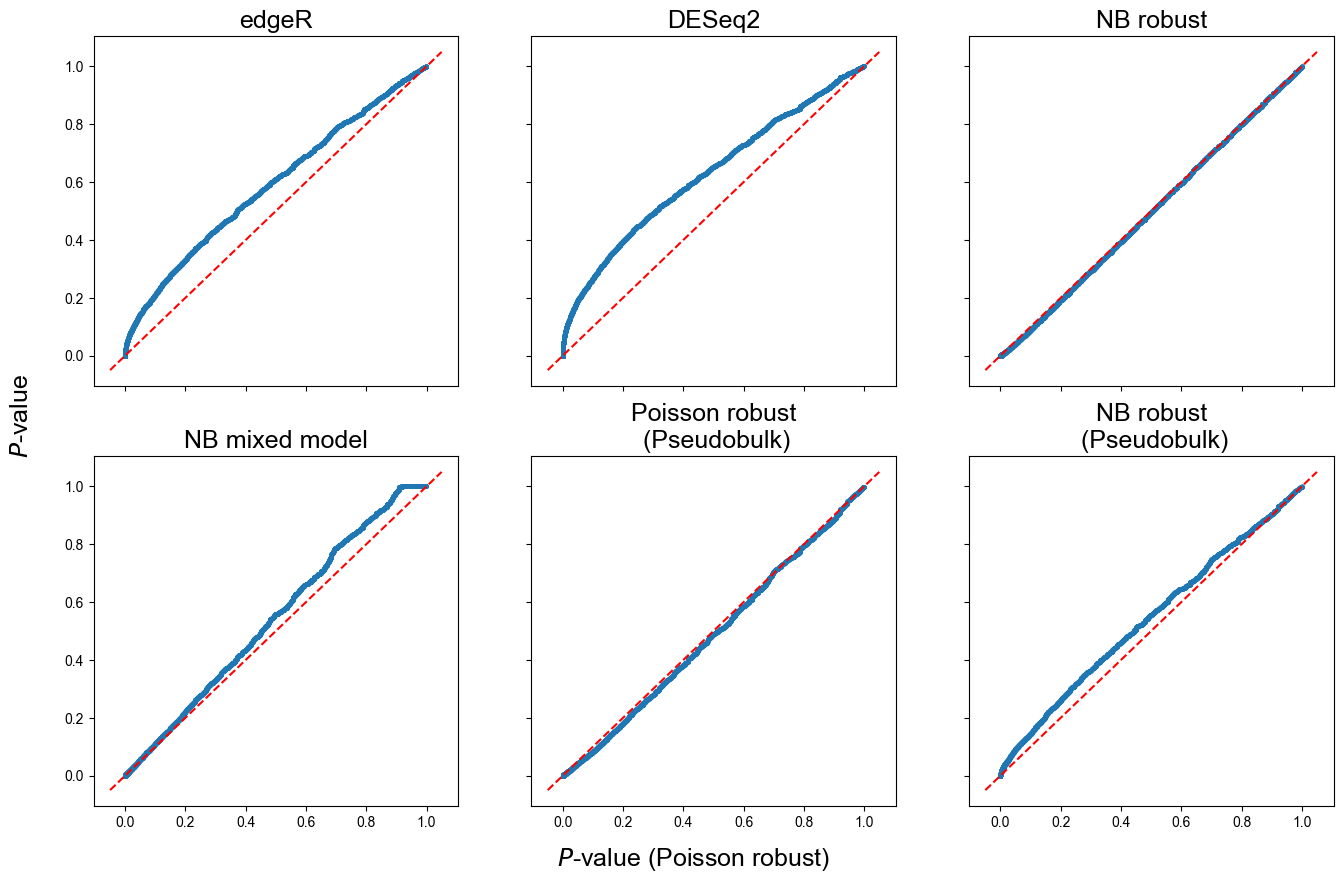

In [57]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 3, figsize=(5*3+1,5*2), sharex=True, sharey=True)


# main scatters
pvals = [gene_p_edger, gene_p_deseq2, gene_p_ggp, gene_p_nbmm, gene_p_pb_rpr, gene_p_pb_ggp]
labels= ['edgeR', 'DESeq2', 'NB robust', 'NB mixed model', 'Poisson robust\n (Pseudobulk)', 'NB robust\n (Pseudobulk)']
for i, pval, label in zip(range(6),pvals,labels):
    row, col = int(i/3), i%3
    ax[row, col].set_title(label, fontsize=18)
    ax[row, col].scatter(np.sort((gene_p_rpr)), np.sort((pval)), s=5)
    ax[row, col].plot([-0.05, 1.05], [-0.05,1.05], ls='--', c='red')
        

   
    

#ax[0,0].set_xlim([-0.5, 700])
#ax[0,0].set_ylim([-0.5, 700])    
fig.text(0.5, 0.05, r'$P$-value (Poisson robust)', fontsize=18, ha='center')
fig.text(0.08, 0.5, r'$P$-value', fontsize=18, rotation=90, ha='center', va='center')



plt.show()

In [40]:
import pickle
 
## Save pickle
with open("power_kang_5000.pickle","wb") as fw:
    pickle.dump(pvals, fw)
 


In [ ]:
## Load pickle
with open("power_kang_5000.pickle","rb") as fr:
    pvals = pickle.load(fr)